In [4]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# ==============================
# 1. Load and Preprocess Data
# ==============================

# Load dataset
file_path = "C:/Users/Medha/Documents/CSUDH/Spring2025/TCGA_Reports.csv"
df = pd.read_csv(file_path)

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Remove missing and duplicate values
df.dropna(subset=["text"], inplace=True)
df.drop_duplicates(subset=["text"], inplace=True)

# ==============================
# 2. Define Labeling Functions
# ==============================

def binary_label(text):
    """Label data for binary classification: Cancer vs Non-Cancer."""
    cancer_keywords = ["cancer", "tumor", "carcinoma", "malignant", "neoplasm"]
    return "Cancer" if any(word in text.lower() for word in cancer_keywords) else "Non-Cancer"

def multiclass_label(text):
    """Label data for multi-class classification."""
    text = text.lower()
    if any(word in text for word in ["malignant", "carcinoma", "neoplasm", "cancer"]):
        return "Cancer"
    elif any(word in text for word in ["benign", "non-cancerous", "harmless"]):
        return "Benign"
    elif any(word in text for word in ["precancerous", "dysplasia"]):
        return "Pre-cancerous"
    elif any(word in text for word in ["normal", "no abnormality", "clear"]):
        return "Normal"
    else:
        return "Other"

# Apply binary classification label
df["binary_label"] = df["text"].apply(binary_label)

# Apply multi-class classification label
df["multiclass_label"] = df["text"].apply(multiclass_label)

# Check class distribution
print("\nBinary Label Distribution:")
print(df["binary_label"].value_counts())
print("\nMulti-Class Label Distribution:")
print(df["multiclass_label"].value_counts())

print("-----------------------------------------------------------------------------------------------------------------")

print("7TH APRIL 2025\n\nAnalysing Dataset for clarity....\n\n")
# Basic info
print("Shape of dataset:", df.shape)
print("\nColumn types:")
print(df.dtypes)

# Peek at data
df.head()

print("\n\nMissing Values")
print(df.isnull().sum())




Checking for missing values:
patient_filename    0
text                0
dtype: int64

Binary Label Distribution:
binary_label
Cancer        9327
Non-Cancer     178
Name: count, dtype: int64

Multi-Class Label Distribution:
multiclass_label
Cancer           8470
Other             506
Normal            448
Benign             80
Pre-cancerous       1
Name: count, dtype: int64
-----------------------------------------------------------------------------------------------------------------
7TH APRIL 2025

Analysing Dataset for clarity....


Shape of dataset: (9505, 4)

Column types:
patient_filename    object
text                object
binary_label        object
multiclass_label    object
dtype: object


Missing Values
patient_filename    0
text                0
binary_label        0
multiclass_label    0
dtype: int64


Index(['patient_filename', 'text', 'binary_label', 'multiclass_label'], dtype='object')

Binary Label Distribution
binary_label
Cancer        9327
Non-Cancer     178
Name: count, dtype: int64


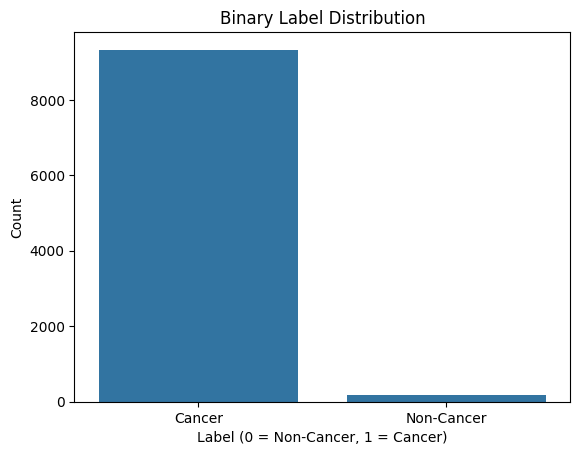


Multiclass Label Distribution
multiclass_label
Cancer           8470
Other             506
Normal            448
Benign             80
Pre-cancerous       1
Name: count, dtype: int64


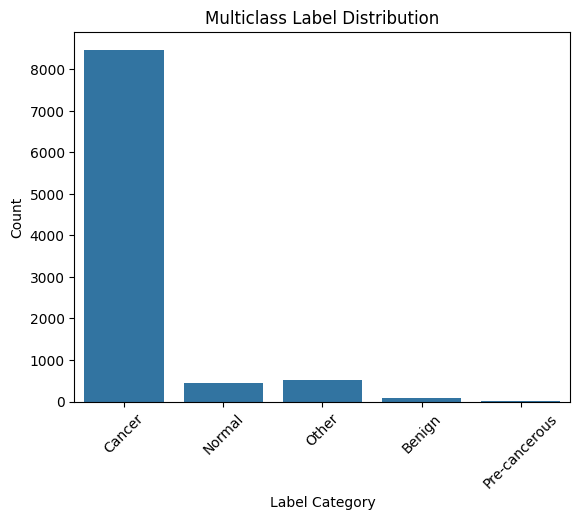

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df.columns)

# Distribution plot
print("\nBinary Label Distribution")
print(df['binary_label'].value_counts())
sns.countplot(x='binary_label', data=df)
plt.title("Binary Label Distribution")
plt.xlabel("Label (0 = Non-Cancer, 1 = Cancer)")
plt.ylabel("Count")
plt.show()

print("\nMulticlass Label Distribution")
print(df['multiclass_label'].value_counts())
sns.countplot(x='multiclass_label', data=df)
plt.title("Multiclass Label Distribution")
plt.xlabel("Label Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


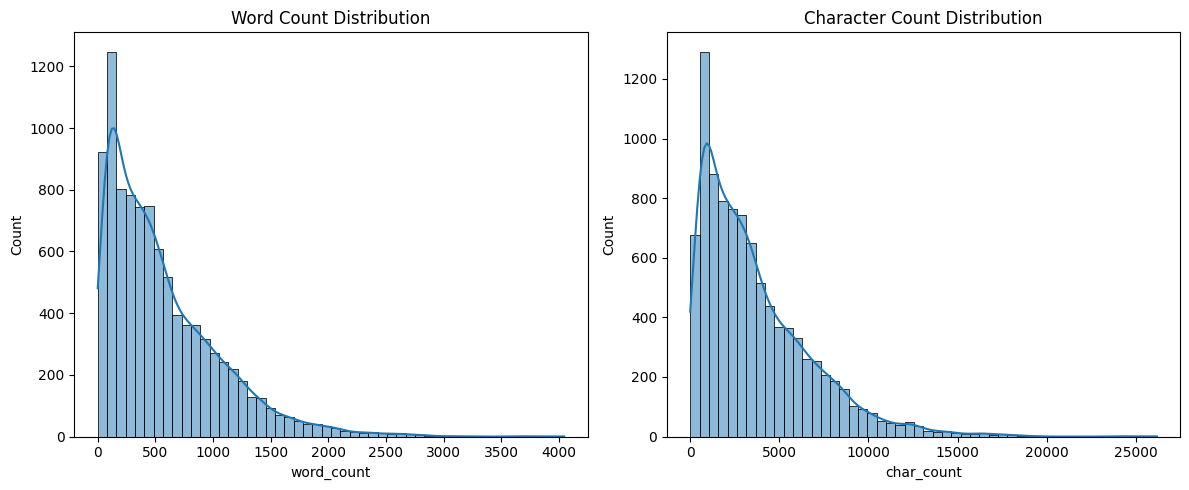

Average word count: 560.9814834297738
Average char count: 3671.8004208311413


In [6]:
# Word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title("Word Count Distribution")

plt.subplot(1, 2, 2)
sns.histplot(df['char_count'], bins=50, kde=True)
plt.title("Character Count Distribution")

plt.tight_layout()
plt.show()

# Mean/Median
print("Average word count:", df['word_count'].mean())
print("Average char count:", df['char_count'].mean())


In [7]:
print("Convert Labels to Numeric\n\n")

# Convert binary_label to 0/1
df['binary_label'] = df['binary_label'].map({'Cancer': 1, 'Non-Cancer': 0})

# Optional: Convert multiclass_label to category if needed
df['multiclass_label'] = df['multiclass_label'].astype('category')

Convert Labels to Numeric




In [24]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

print("REMOVING STOP WORDS AND EXTRACTING COMMON WORDS IN CANCER AND NON-CANCER CLASSES\n\n")
# Download stopwords if not already downloaded
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_top_words(df, label_val, label_col='binary_label', n=100):
    # Filter out stopwords
    texts = df[df[label_col] == label_val]['text'].str.lower().str.split()
    all_words = [word for tokens in texts for word in tokens if word not in stop_words]
    return Counter(all_words).most_common(n)

# Get the top 20 words in Cancer (1) class
cancer_top_words = get_top_words(df, 1)

# Get the top 20 words in Non-Cancer (0) class
non_cancer_top_words = get_top_words(df, 0)

# Extract only the words from the top word counts (ignoring counts)
cancer_words = set([word for word, count in cancer_top_words])
non_cancer_words = set([word for word, count in non_cancer_top_words])

# Find common words between the two classes
common_words = cancer_words.intersection(non_cancer_words)

# Output the common words
print("Common words between Cancer and Non-Cancer classes:")
print(common_words)

# Find non-common words in both classes
cancer_unique = cancer_words - non_cancer_words
non_cancer_unique = non_cancer_words - cancer_words

print("\nNon-common words in Cancer class (1):")
print(cancer_unique)

print("\nNon-common words in Non-Cancer class (0):")
print(non_cancer_unique)


REMOVING STOP WORDS AND EXTRACTING COMMON WORDS IN CANCER AND NON-CANCER CLASSES


Common words between Cancer and Non-Cancer classes:
{'tissue.', 'description:', '1', '1.', 'cm', 'labeled', 'and.', '-', 'sections', 'submitted', 'cell', 'the.', 'section', 'cm.', 'frozen', 'of.', '3', 'is.', 'diagnosis.', 'grade', 'anterior', 'gross', 'diagnosis', 'clinical', 'received', 'a.', 'fresh', '2', 'x', 'lymph', 'measuring', 'specimen', 'right', ':', 'diagnosis:', 'present.', 'tissue', 'mass', 'left'}

Non-common words in Cancer class (1):
{'metastatic', 'identified', '0.3', 'nodes.', 'invasion:', 'surface', 'measures', 'identified.', 'nodes,', 'renal', 'nodes', '2.', 'entirely', 'in.', 'margin', 'tumor', 'consists', 'formalin', 'posterior', 'surgical', '0.2', 'b.', '3.', '2.5', 'one', 'two', 'level', 'pathologic', 'part', 'resection', 'additional', 'type:', 'node,', 'portion', 'representative', 'inked', 'negative', 'greatest', '1.5', 'invasive', '0.5', 'cassette', 'carcinoma', 'c.', 'tumor.', 

In [18]:
# Filter cancer class rows
print("DETECTED IMBALANCE IN CLASS DISTRIBUTION\n\n")
print("FINDING FAULTS IN CLASSIFICATION OF CANCER CLASS")
print(df['binary_label'].unique())
cancer_texts = df[df['binary_label'] == 1]['text'].str.lower()

# Count how many times "no" and "non" appear across all cancer texts
no_count = cancer_texts.str.count(r'\bno \b').sum()
non_count = cancer_texts.str.count(r'\bnon\b').sum()

print(f'Frequency of the word "no" in Cancer class: {no_count}')
print(f'Frequency of the word "non" in Cancer class: {non_count}')

text = cancer_texts[cancer_texts.str.contains(r'\bno \b', regex=True)].sample(1).tolist()[0]

text_lower = text.lower()

# Find indices of 'no' and 'non' as whole words
no_matches = [m.start() for m in re.finditer(r'\bno \b', text_lower)]
non_matches = [m.start() for m in re.finditer(r'\bnon\b', text_lower)]

# Print results with context
print("Occurrences of 'no':")
for idx in no_matches:
    print(f"Index {idx}: '{text_lower[idx-20:idx+20]}'")

print("\nOccurrences of 'non':")
for idx in non_matches:
    print(f"Index {idx}: '{text_lower[idx:idx+10]}'")


DETECTED IMBALANCE IN CLASS DISTRIBUTION


FINDING FAULTS IN CLASSIFICATION OF CANCER CLASS
[1 0]
Frequency of the word "no" in Cancer class: 24925
Frequency of the word "non" in Cancer class: 3390
Occurrences of 'no':
Index 275: 'g 125 x 80 x 65 mm. no parietal pleura i'
Index 1483: 'n is labelled `left no 10 lymph node' an'
Index 1843: 'fied [1g]. there is no vascular invasion'
Index 1898: 'ermeation is. seen. no perineural invasi'
Index 2653: 'aximal dimension. - no lymphatic invasio'
Index 2819: 'ilar lymph nodes. - no evidence of malig'
Index 2848: 'ce of malignancy in no 10 lymph node (sp'

Occurrences of 'non':
Index 742: 'non-neopla'
Index 2905: 'non-neopla'


In [23]:
# Filter cancer class rows
print("DETECTED IMBALANCE IN CLASS DISTRIBUTION\n\n")
print("FINDING FAULTS IN CLASSIFICATION OF NON-CANCER CLASS")
print(df['binary_label'].unique())
cancer_texts = df[df['binary_label'] == 0]['text'].str.lower()

# Count how many times "no" and "non" appear across all cancer texts
no_count = cancer_texts.str.count(r'\bno \b').sum()
non_count = cancer_texts.str.count(r'\bnon\b').sum()

print(f'Frequency of the word "no" in Cancer class: {no_count}')
print(f'Frequency of the word "non" in Cancer class: {non_count}')

text = cancer_texts[cancer_texts.str.contains(r'\bno \b', regex=True)].sample(2).tolist()

for i in text:
    text_lower = i.lower()
    print("\n\n",text_lower)
    # Find indices of 'no' and 'non' as whole words
    no_matches = [m.start() for m in re.finditer(r'\bno \b', text_lower)]
    non_matches = [m.start() for m in re.finditer(r'\bnon\b', text_lower)]

    # Print results with context
    print("Occurrences of 'no':")
    for idx in no_matches:
        print(f"Index {idx}: '{text_lower[idx-20:idx+20]}'")
    
    print("\nOccurrences of 'non':")
    for idx in non_matches:
        print(f"Index {idx}: '{text_lower[idx:idx+10]}'")


DETECTED IMBALANCE IN CLASS DISTRIBUTION


FINDING FAULTS IN CLASSIFICATION OF NON-CANCER CLASS
[1 0]
Frequency of the word "no" in Cancer class: 127
Frequency of the word "non" in Cancer class: 16


 orinted: clinical consultant & location. unit no. specimen. right globe. clinical details. right eye floaters and visual field defect and flashes of. light since. seen at local eye unit. and ultrasound was suggestive. of collar-stud choroidal melanoma - referred to. diagnosis confirmed. tumour and exudative detachment. largest diameter 11.34mm. thickness 7. 6mm. post ora. macroscopic description. an intact right eye. dimensions: axial 24.5mm, horizontal 23mm, vertical 23mm. cornea: horizontal 12mm, vertical 11mm. optic nerve. length 4mm, diameter 4mm. pupil: regular, normal depth. on trans-illumination, a dark shadow seen inferior. posteriorly measuring approximately 13 x 10mm, and 5mm from. optic disc. plane of section: vertical. intraocular description: on opening, a dome shaped tumour 